In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from hotelling.stats import hotelling_t2
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, r2_score

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout, Concatenate

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Load data

assistments_usage = pd.read_csv('assistments_usage.csv', dtype=str).astype(str)
assistments_usage = assistments_usage.set_index('school_code')
assistments_usage = assistments_usage.astype(int)
assistments_usage = assistments_usage[assistments_usage['in_treatment'] == assistments_usage['used_assistments']]
assistments_usage = assistments_usage.sort_values('school_code')

mass_doe_data = pd.read_csv('mcas_exports/csv/mass_doe_data.csv', dtype=str).astype(str)
mass_doe_data = mass_doe_data.set_index('school_code')
float_columns = [c for c in mass_doe_data if c != 'prior_performance']
mass_doe_data[float_columns] = mass_doe_data[float_columns].astype(float)
mass_doe_data['prior_performance'] = mass_doe_data['prior_performance'].apply(lambda x: np.array(eval(x.replace('nan', 'np.nan'))))
mass_doe_data = mass_doe_data[mass_doe_data.index.isin(assistments_usage.index)]
mass_doe_data = mass_doe_data.sort_values('school_code')

flat_mass_doe_data = pd.read_csv('mcas_exports/csv/flat_mass_doe_data.csv', dtype=str).astype(str)
flat_mass_doe_data = flat_mass_doe_data.set_index('school_code')
flat_mass_doe_data = flat_mass_doe_data.astype(float)
flat_mass_doe_data = flat_mass_doe_data[flat_mass_doe_data.index.isin(assistments_usage.index)]
flat_mass_doe_data = flat_mass_doe_data.sort_values('school_code')

treatment = assistments_usage['in_treatment'].values.reshape(-1, 1)
demographics = mass_doe_data.drop(columns='prior_performance').values
prior_performance = np.array(mass_doe_data['prior_performance'].tolist())
school_code_index = mass_doe_data.index.values

In [3]:
score_dfs = []

Model AUC: mean = 0.744; std = 0.06247
Model R²: mean = -2.05; std = 0.3905


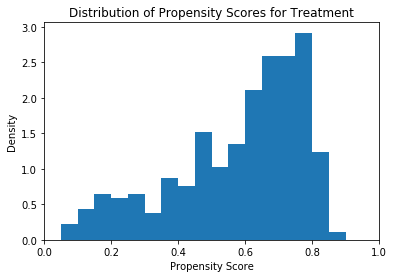

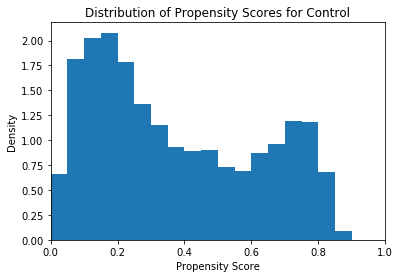

In [4]:
# Get model stats and propensity scores for every school using a neural network

TRIALS = 10

ff_X = demographics
lstm_X = prior_performance
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1
s = school_code_index

school_codes = []
propensity_scores = []
treatments = []
aucs = []
r2s = []
for i in range(TRIALS):
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(ff_X, y):

        # Clear session so models don't pile up
        keras.backend.clear_session()

        # Split data into training and testing splits
        train_ff_X, test_ff_X = ff_X[train_index], ff_X[test_index]
        train_lstm_X, test_lstm_X = lstm_X[train_index], lstm_X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        train_w, test_w = w[train_index], w[test_index]
        train_s, test_s = s[train_index], s[test_index]

        # Normalize the input data based on the training data distribution
        ff_scaler = StandardScaler().fit(train_ff_X)
        train_ff_X = np.nan_to_num(ff_scaler.transform(train_ff_X))
        test_ff_X = np.nan_to_num(ff_scaler.transform(test_ff_X))

        train_lstm_X_shape = train_lstm_X.shape
        train_stacked_lstm_X = train_lstm_X.reshape(-1, train_lstm_X_shape[-1])
        lstm_scaler = StandardScaler().fit(train_stacked_lstm_X)
        train_lstm_X = np.nan_to_num(lstm_scaler.transform(train_stacked_lstm_X)).reshape(train_lstm_X_shape)
        test_lstm_X_shape = test_lstm_X.shape
        test_stacked_lstm_X = test_lstm_X.reshape(-1, test_lstm_X_shape[-1])
        test_lstm_X = np.nan_to_num(lstm_scaler.transform(test_stacked_lstm_X)).reshape(test_lstm_X_shape)

        # Create the neural network
        ff_input_layer = Input(shape=train_ff_X[0].shape)
        ff_model = Dense(units=64, activation='sigmoid')(ff_input_layer)
        ff_model = Dropout(rate=0.5)(ff_model)

        lstm_input_layer = Input(shape=train_lstm_X[0].shape)
        lstm_model = Masking(mask_value=0.0)(lstm_input_layer)
        lstm_model = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(lstm_model)

        model = Concatenate()([ff_model, lstm_model])
        output_layer = Dense(units=1, activation='sigmoid')(model)

        combined_model = Model([ff_input_layer, lstm_input_layer], output_layer)
        combined_model.compile(optimizer='adam', loss='binary_crossentropy')

        # Train the neural network
        es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
        combined_model.fit(x=[train_ff_X, train_lstm_X],
                           y=train_y,
                           epochs=1000,
                           validation_split=0.25,
                           callbacks=es,
                           sample_weight=train_w,
                           verbose=0)

        # Use the neural network to predict the held-out fold
        pred_y = combined_model.predict([test_ff_X, test_lstm_X]).flatten()

        # Update propensity scores and metrics
        school_codes.extend(test_s.tolist())
        propensity_scores.extend(pred_y.tolist())
        treatments.extend(test_y.flatten().tolist())
        aucs.append(roc_auc_score(test_y.flatten(), pred_y))
        r2s.append(r2_score(test_y.flatten(), pred_y))

scores = pd.DataFrame([school_codes, propensity_scores, treatments], 
                      index=['school_code', 'propensity_score', 'in_treatment']).T
scores['propensity_score'] = scores['propensity_score'].astype(float)
scores['in_treatment'] = scores['in_treatment'].astype(int)
scores = scores.groupby('school_code').mean().reset_index()
scores['model'] = 'Average Out-of-Bag Neural Net'
score_dfs.append(scores)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

Model AUC: mean = 0.8368; std = 0
Model R²: mean = -1.701; std = 0


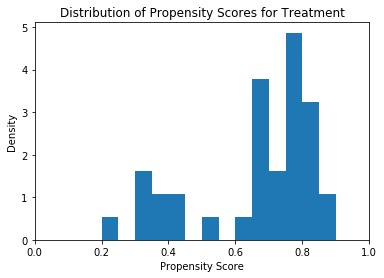

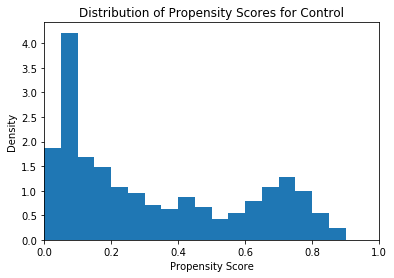

In [5]:
# Get model stats and propensity scores for every school using a neural network

TRIALS = 1

ff_X = demographics
lstm_X = prior_performance
y = treatment
w = treatment * (len(treatment) / treatment.sum() - 1) + 1
s = school_code_index

school_codes = []
propensity_scores = []
treatments = []
aucs = []
r2s = []
for i in range(TRIALS):

    # Clear session so models don't pile up
    keras.backend.clear_session()

    # Normalize the input data based on the training data distribution
    ff_scaler = StandardScaler().fit(ff_X)
    ff_X = np.nan_to_num(ff_scaler.transform(ff_X))

    lstm_X_shape = lstm_X.shape
    stacked_lstm_X = lstm_X.reshape(-1, lstm_X_shape[-1])
    lstm_scaler = StandardScaler().fit(stacked_lstm_X)
    lstm_X = np.nan_to_num(lstm_scaler.transform(stacked_lstm_X)).reshape(lstm_X_shape)

    # Create the neural network
    ff_input_layer = Input(shape=ff_X[0].shape)
    ff_model = Dense(units=64, activation='sigmoid')(ff_input_layer)
    ff_model = Dropout(rate=0.5)(ff_model)

    lstm_input_layer = Input(shape=lstm_X[0].shape)
    lstm_model = Masking(mask_value=0.0)(lstm_input_layer)
    lstm_model = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(lstm_model)

    model = Concatenate()([ff_model, lstm_model])
    output_layer = Dense(units=1, activation='sigmoid')(model)

    combined_model = Model([ff_input_layer, lstm_input_layer], output_layer)
    combined_model.compile(optimizer='adam', loss='binary_crossentropy')

    # Train the neural network
    es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
    combined_model.fit(x=[ff_X, lstm_X],
                       y=y,
                       epochs=1000,
                       validation_split=0.25,
                       callbacks=es,
                       sample_weight=w,
                       verbose=0)

    # Use the neural network to predict the held-out fold
    pred_y = combined_model.predict([ff_X, lstm_X]).flatten()

    # Update propensity scores and metrics
    school_codes.extend(s.tolist())
    propensity_scores.extend(pred_y.tolist())
    treatments.extend(y.flatten().tolist())
    aucs.append(roc_auc_score(y.flatten(), pred_y))
    r2s.append(r2_score(y.flatten(), pred_y))

scores = pd.DataFrame([school_codes, propensity_scores, treatments], 
                      index=['school_code', 'propensity_score', 'in_treatment']).T
scores['propensity_score'] = scores['propensity_score'].astype(float)
scores['in_treatment'] = scores['in_treatment'].astype(int)
scores = scores.groupby('school_code').mean().reset_index()
scores['model'] = 'One Shot Neural Net'
score_dfs.append(scores)

# Display Findings

print(f'Model AUC: mean = {np.mean(aucs):.4g}; std = {np.std(aucs):.4g}')
print(f'Model R\u00b2: mean = {np.mean(r2s):.4g}; std = {np.std(r2s):.4g}')

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 1], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Treatment')
plt.show()

plt.figure()
plt.hist(np.array(propensity_scores)[np.array(treatments) == 0], bins=np.arange(0, 1.01, 0.05), density=True)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Distribution of Propensity Scores for Control')
plt.show()

In [6]:
# Determine control schools

scores = pd.concat(score_dfs, axis=0, sort=False)

def mark_control(df, n):
    nn = NearestNeighbors(n_neighbors=n + 1)
    nn.fit(df[['propensity_score']].values)
    treatment_scores = df[df['in_treatment'] == 1][['propensity_score']].values
    control_indicies = nn.kneighbors(treatment_scores, return_distance=False).flatten()
    df['in_control'] = ((df['in_treatment'] == 0) & df.index.isin(control_indicies)).astype(int)
    return df

scores = scores.groupby('model').apply(lambda x: mark_control(x, 3))
scores = scores.set_index('school_code')

In [30]:
SAMPLES = 100

normalized_covariates = ((flat_mass_doe_data - flat_mass_doe_data.mean()) / flat_mass_doe_data.std()).fillna(0)

def get_condition_similarity(df):
    control = normalized_covariates[normalized_covariates.index.isin(df[df['in_control'] == 1].index)].values
    treatment = normalized_covariates[normalized_covariates.index.isin(df[df['in_treatment'] == 1].index)].values
    #_, _, p, _ = hotelling_t2(control, treatment)
    p = np.mean(ttest_ind(control, treatment, equal_var=False), axis=1)[1]
    return p

similarity = scores.groupby('model').apply(lambda x: get_condition_similarity(x))
display(similarity)

model
Average Out-of-Bag Neural Net    0.443472
One Shot Neural Net              0.444457
dtype: float64

In [31]:
scores = scores[scores['model'] == 'One Shot Neural Net']
scores = scores[['propensity_score', 'in_treatment', 'in_control']]
scores.to_csv('propensity_scores_and_conditions.csv')